In [2]:
from tqdm import tqdm
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from dataset import *
from utils import Transform3D, model_to_syncbn
# from models import ResNet18, ResNet34, ResNet50
from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter

import medmnist
from medmnist import INFO, Evaluator
from medmnist import OrganMNIST3D

from torchvision.models import resnet18, resnet34, resnet50
from torchvision.models import swin_v2_t, efficientnet_v2_s

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [ ]:
# %tensorboard --logdir logs
%load_ext tensorboard


In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


Using downloaded and verified file: /Users/vemundlund/.medmnist/organmnist3d.npz
Using downloaded and verified file: /Users/vemundlund/.medmnist/organmnist3d.npz
Using downloaded and verified file: /Users/vemundlund/.medmnist/organmnist3d.npz
Using downloaded and verified file: /Users/vemundlund/.medmnist/organmnist3d.npz
==> Building and training model...
Running iteration 0 of 16
Epoch 0 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 3.5421809915636406
cur_best_auc: 0.39180732365736176
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.44it/s]


Epoch loss 2.842540580718244
cur_best_auc: 0.5298332026932134
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s]


Epoch loss 2.6143514758250754
cur_best_auc: 0.5836190807906655
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.48it/s]


Epoch loss 2.6707161645420263
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:40<00:00,  1.49it/s]


Epoch loss 2.640282826345475
cur_best_auc: 0.6697451045098372
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.47it/s]


Epoch loss 2.476929199500162
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:40<00:00,  1.50it/s]


Epoch loss 2.493593755315562
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.47it/s]


Epoch loss 2.515837716274574
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.46it/s]


Epoch loss 2.4605434644417685
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.43it/s]


Epoch loss 2.46761769935733
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.46it/s]


Epoch loss 2.4704987299246866
cur_best_auc: 0.6731802032741705
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.45it/s]


Epoch loss 2.4509480859412522
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:43<00:00,  1.41it/s]


Epoch loss 2.499559547080368
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:43<00:00,  1.40it/s]


Epoch loss 2.6870328871930234
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.39it/s]


Epoch loss 2.5196866871880705
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:43<00:00,  1.39it/s]


Epoch loss 2.5399923011904857
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:43<00:00,  1.39it/s]


Epoch loss 2.465305664500252
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:43<00:00,  1.39it/s]


Epoch loss 2.478743658691156
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.5593575141468987
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.4661439207733653
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.459866261873089
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.435726939654741
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.4858650731258707
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.4659700862696914
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.4972942188137868
organmnist3d
train  auc: 0.66092  acc: 0.11831
val  auc: 0.67318  acc: 0.09938
test  auc: 0.63662  acc: 0.11311

Running iteration 1 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 1.9916702997489053
cur_best_auc: 0.959076240791076
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 1.4446142872825998
cur_best_auc: 0.9861875688864207
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 1.2223581359034679
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 1.0334473574747804
cur_best_auc: 0.9931011580131194
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.8976730870418861
cur_best_auc: 0.9996644989972812
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.8728142016735233
cur_best_auc: 0.9998224779046697
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 0.7119564392039033
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.702400165625283
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.6282966823362913
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.6796396103550176
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.5498411088693337
cur_best_auc: 0.9999054999055
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.5924210946579449
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.4817324743651953
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.5851571817012107
cur_best_auc: 0.9999584889995848
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 0.39601497920077355
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 0.4299542015326805
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.382516797265557
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 0.4453296315108166
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 0.6369302746702413
cur_best_auc: 1.0
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.5670604529927988
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.3854865572247349
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.41870939927022965
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.4108308252618938
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.35873683697742514
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.3049364642957684
organmnist3d
train  auc: 0.99792  acc: 0.94753
val  auc: 1.00000  acc: 0.99379
test  auc: 0.98516  acc: 0.82787

Running iteration 2 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 2.368760636595429
cur_best_auc: 0.8228498799445364
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 2.108273060595403
cur_best_auc: 0.9249817295297036
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.7575383909413071
cur_best_auc: 0.9525255784534413
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.5403959927011708
cur_best_auc: 0.9793438734758034
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 1.3358355135214133
cur_best_auc: 0.9899031813362356
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 1.2159986388487893
cur_best_auc: 0.9913299268200795
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.060688316822052
cur_best_auc: 0.9959510914045634
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.9389956373660291
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.8832356387474498
cur_best_auc: 0.9977586462499652
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.8698657257635085
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.7773388160056756
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.7207790212553056
cur_best_auc: 0.9992174568914854
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.655850208440765
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.5759211270535578
cur_best_auc: 0.9994007180336507
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.5550656484775855
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.53762812888036
cur_best_auc: 0.9994982946618394
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.5441912656924763
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.4614714737065503
cur_best_auc: 0.9996277386688345
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.42478271756992964
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.43901904757882726
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 0.4475764353744319
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.41484694256157173
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.40068046174577027
cur_best_auc: 0.9997668262974386
cur_best_epoch 22
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.36981566445749314
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.35612595209577047
organmnist3d
train  auc: 0.99981  acc: 0.97428
val  auc: 0.99977  acc: 0.98137
test  auc: 0.98422  acc: 0.82295

Running iteration 3 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 2.448676519706601
cur_best_auc: 0.5679305484533812
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.4390359120290785
cur_best_auc: 0.6431983122266108
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.3926725973848435
cur_best_auc: 0.6466621300779669
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.3617284063433037
cur_best_auc: 0.7136130962601324
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.34770335916613
cur_best_auc: 0.7411485101568055
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.3139332747850263
cur_best_auc: 0.7594245308635859
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.3028413702229984
cur_best_auc: 0.8215126114332492
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.260810375213623
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.2301427614493448
cur_best_auc: 0.8733061465509192
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.2143951556721673
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 2.2121915055102988
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.154423780128604
cur_best_auc: 0.876138765475211
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.1604117350500136
cur_best_auc: 0.90936782934062
cur_best_epoch 12
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 2.117304491215065
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.0586081020167617
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.053101393043018
cur_best_auc: 0.9212554132635014
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.9914025498218224
cur_best_auc: 0.9262130935825662
cur_best_epoch 16
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 1.9652887055131256
cur_best_auc: 0.9423902466000929
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 1.959459517822891
cur_best_auc: 0.9472177068573587
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 1.9109288825363409
cur_best_auc: 0.9512629437333967
cur_best_epoch 19
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 1.8911142583753242
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.8568780265870641
cur_best_auc: 0.9525476279570927
cur_best_epoch 21
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 1.7992768248573678
cur_best_auc: 0.9705564951554656
cur_best_epoch 22
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 1.7504545235243
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.7305803689800325
cur_best_auc: 0.972957478305463
cur_best_epoch 24
organmnist3d
train  auc: 0.93767  acc: 0.61831
val  auc: 0.97296  acc: 0.77019
test  auc: 0.90658  acc: 0.51311

Running iteration 4 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 3.1616426647686566
cur_best_auc: 0.527519364043662
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.7301762143119435
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.6075642343427314
cur_best_auc: 0.5621260445071334
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.5045279323077594
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.5786830675406534
cur_best_auc: 0.5713646595738119
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.457123263937528
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.548587912418803
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.500497552215076
cur_best_auc: 0.6117557601013925
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.4710629240411226
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 2.432149785463927
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.5073196262609763
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.3918427092130066
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.391545377793859
cur_best_auc: 0.6347780708813359
cur_best_epoch 12
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.4380711453859925
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.4857241755626243
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.5090747739447923
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.4840927632128604
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.486267023399228
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.36it/s]


Epoch loss 2.459972463670324
cur_best_auc: 0.6351814233597273
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 2.445650694800205
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:51<00:00,  1.19it/s]


Epoch loss 2.4783704319938282
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]


Epoch loss 2.4400982778580462
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.5253460915362247
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.677714132871784
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.5209946632385254
organmnist3d
train  auc: 0.63359  acc: 0.12140
val  auc: 0.63518  acc: 0.09938
test  auc: 0.62010  acc: 0.11475

Running iteration 5 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.002022356283469
cur_best_auc: 0.9497159596046884
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]


Epoch loss 1.4256239044861716
cur_best_auc: 0.9840649549647651
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 1.2583281114453175
cur_best_auc: 0.99775454226304
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 1.103967598227204
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]


Epoch loss 1.0244226436145971
cur_best_auc: 0.9989307604749412
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.9043998508179774
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.6805916228255288
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.7892150226675096
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.7245077852342949
cur_best_auc: 0.9994154329947906
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.7369063657815339
cur_best_auc: 0.9998582498582498
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.5913432514081236
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.7785637593660198
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.5465275735640135
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.6268187945739168
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.5803928203025802
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.5220486216369222
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.45497406909211735
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.2986956683949369
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.36049002005917125
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.3014107769752135
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.5015916473186407
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.43115583898835497
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.4404633793918813
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.33884178251638764
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.31173156501084076
organmnist3d
train  auc: 0.99853  acc: 0.93827
val  auc: 0.99986  acc: 0.97516
test  auc: 0.98589  acc: 0.80820

Running iteration 6 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.304243423899666
cur_best_auc: 0.8678987061789546
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.0157946875837984
cur_best_auc: 0.9295355126255128
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]


Epoch loss 1.6783726078565004
cur_best_auc: 0.976889960863841
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.4049223465997664
cur_best_auc: 0.9827967820025553
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.2176194464574095
cur_best_auc: 0.9891767215233469
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.0185981920508087
cur_best_auc: 0.9956491512656136
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.9061772901503766
cur_best_auc: 0.9959313267085385
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.8615177552231023
cur_best_auc: 0.9969417365494313
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.7917480913342022
cur_best_auc: 0.9971012104970199
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.7267630212619657
cur_best_auc: 0.9978769515951512
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.6403011210629197
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.6323130106339689
cur_best_auc: 0.9983372205215786
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5844094416157144
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5399571481298228
cur_best_auc: 0.9987744586719841
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5083176874723591
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5011061732886267
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4405888956589777
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.46145709884948416
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 0.4074905923888332
cur_best_auc: 0.9993177495992416
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.40692606122523056
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.3252583726263437
cur_best_auc: 0.9997787184116511
cur_best_epoch 20
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.34989095589176555
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.29186460656709357
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.3236228211126367
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.28578223343022535
organmnist3d
train  auc: 0.99981  acc: 0.98457
val  auc: 0.99978  acc: 0.97516
test  auc: 0.98393  acc: 0.82131

Running iteration 7 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.28s/it]


Epoch loss 2.448452226451186
cur_best_auc: 0.6372757168624926
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.4165608101203793
cur_best_auc: 0.6510543459961677
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.3926262621019707
cur_best_auc: 0.6811457751485274
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.3908669088707595
cur_best_auc: 0.7555580895911361
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.3261224637266067
cur_best_auc: 0.7842398826415485
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.306814799543287
cur_best_auc: 0.7894608969723688
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.282591667331633
cur_best_auc: 0.8514242731037289
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.2617886691796976
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:21<00:00,  1.33s/it]


Epoch loss 2.2316909227214876
cur_best_auc: 0.8954384383184766
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]


Epoch loss 2.186203335152298
cur_best_auc: 0.9273138803741408
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.1622984507044807
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.1444645103861073
cur_best_auc: 0.9302028599059196
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.09898542966999
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.06223593578964
cur_best_auc: 0.9364063994574536
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.0373389310524113
cur_best_auc: 0.9537870968940396
cur_best_epoch 14
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.0065057727157094
cur_best_auc: 0.9597853604522167
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.956449203803891
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.8915904056830484
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 1.8843589102635618
cur_best_auc: 0.9631119644683312
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.8012733850322786
cur_best_auc: 0.9696277774448415
cur_best_epoch 19
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.8035469856418547
cur_best_auc: 0.9712137865636511
cur_best_epoch 20
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.7347673646739272
cur_best_auc: 0.9767696329199178
cur_best_epoch 21
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.7345250727700405
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]


Epoch loss 1.6991681427252097
cur_best_auc: 0.9783260499541723
cur_best_epoch 23
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 1.6636863536522037
cur_best_auc: 0.9815900193436754
cur_best_epoch 24
organmnist3d
train  auc: 0.95420  acc: 0.68621
val  auc: 0.98159  acc: 0.78261
test  auc: 0.92478  acc: 0.58852

Running iteration 8 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 3.2577504681759195
cur_best_auc: 0.5885491299919448
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.8359996334451143
cur_best_auc: 0.6279711715762684
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.597381525352353
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.6308529572408705
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.5698375975499386
cur_best_auc: 0.6383267345480431
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.475469886279497
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.460084192088393
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.5480744721459563
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.5521391376120146
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.5016351566940056
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.662938856687702
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.504386651711386
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.4538902532858926
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.53622425970484
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.29s/it]


Epoch loss 2.5606624415663424
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.5070757553225658
cur_best_auc: 0.6646948761363894
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.5129840569417983
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.616113815151277
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.5456213208495595
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.5924366106752488
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.4964551573894065
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 2.5222161382925314
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.52540162743115
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.5511243890543454
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.433682472979436
organmnist3d
train  auc: 0.62005  acc: 0.11831
val  auc: 0.66469  acc: 0.08696
test  auc: 0.61993  acc: 0.11311

Running iteration 9 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:13<00:00,  1.20s/it]


Epoch loss 2.0679244682437083
cur_best_auc: 0.9428757049028562
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:12<00:00,  1.19s/it]


Epoch loss 1.5202490726455313
cur_best_auc: 0.9769672151150322
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:18<00:00,  1.28s/it]


Epoch loss 1.3350134736201802
cur_best_auc: 0.985739183438204
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.1411142085419326
cur_best_auc: 0.9926111260303369
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 1.0133183090413203
cur_best_auc: 0.9959174236476301
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.8995759404096447
cur_best_auc: 0.9980523855316593
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.8244002153638934
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.8570093927813358
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.7309545576572418
cur_best_auc: 0.9999558264864387
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 0.6079695727981504
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5501153618097305
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.6181933459688406
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.47634080931788586
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.5043368276025428
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.46895678451315304
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.4575852039346441
cur_best_auc: 1.0
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.34078841219793576
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.5023902399373836
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.4497035084383898
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch loss 0.30215809491203455
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.2796853727462595
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.35477472872274823
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.25129272170425926
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:51<00:00,  1.18it/s]


Epoch loss 0.27393357900398796
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.44it/s]


Epoch loss 0.2922902007846803
organmnist3d
train  auc: 0.99985  acc: 0.98354
val  auc: 1.00000  acc: 0.97516
test  auc: 0.98981  acc: 0.84426

Running iteration 10 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.43it/s]


Epoch loss 2.3818904884525987
cur_best_auc: 0.7777113789218183
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.45it/s]


Epoch loss 2.1768350835706367
cur_best_auc: 0.8861457888685241
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.45it/s]


Epoch loss 1.8747352127169
cur_best_auc: 0.9571535305136231
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:42<00:00,  1.43it/s]


Epoch loss 1.5745880134770127
cur_best_auc: 0.9843554001382272
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:41<00:00,  1.46it/s]


Epoch loss 1.360740776921882
cur_best_auc: 0.9874417798269175
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.38it/s]


Epoch loss 1.1698815148384845
cur_best_auc: 0.995475537076691
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 1.0562971361347886
cur_best_auc: 0.9964522975594668
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.35it/s]


Epoch loss 0.9569447016129728
cur_best_auc: 0.9984021792847094
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:44<00:00,  1.37it/s]


Epoch loss 0.9163373435129885
cur_best_auc: 0.9987295136499102
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 0.8022650392329107
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 0.7850477724778847
cur_best_auc: 0.9987886768336337
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.6468042887625147
cur_best_auc: 0.9990146880716902
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.6516838464580599
cur_best_auc: 0.9996146639917185
cur_best_epoch 12
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.30it/s]


Epoch loss 0.627527833473487
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 0.5859081713391132
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 0.5402275990755832
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 0.5143359369430386
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 0.47570702971005047
cur_best_auc: 0.9996542599990875
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.46316867627081326
cur_best_auc: 0.9997860330196713
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 0.41813265993336185
cur_best_auc: 1.0
cur_best_epoch 19
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.33it/s]


Epoch loss 0.4398691821538034
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 0.37353369471479636
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 0.3638604667465218
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.30it/s]


Epoch loss 0.36168176021243703
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 0.35027445761151
organmnist3d
train  auc: 0.99964  acc: 0.98148
val  auc: 1.00000  acc: 0.98137
test  auc: 0.98503  acc: 0.79836

Running iteration 11 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.27it/s]


Epoch loss 2.424474669284508
cur_best_auc: 0.5760622859600524
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.4113666034135663
cur_best_auc: 0.6157933375138845
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.369736382218658
cur_best_auc: 0.6909434304088126
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 2.3673161756796914
cur_best_auc: 0.715112312251964
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 2.345782733354412
cur_best_auc: 0.760184610642035
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.26it/s]


Epoch loss 2.3118702270945564
cur_best_auc: 0.7801767713312255
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.27it/s]


Epoch loss 2.2979635097941413
cur_best_auc: 0.8303959111064856
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.26it/s]


Epoch loss 2.2871755771949642
cur_best_auc: 0.8846567767040278
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.249632788486168
Epoch 9 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.2129136363013844
Epoch 10 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.26it/s]


Epoch loss 2.1963609281133434
cur_best_auc: 0.8900377724785096
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [00:48<00:00,  1.27it/s]


Epoch loss 2.157122582685752
cur_best_auc: 0.9074646341220142
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.130745496906218
Epoch 13 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.27it/s]


Epoch loss 2.10756576647524
cur_best_auc: 0.9200635749977569
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 2.0727165898338695
cur_best_auc: 0.9252289464885746
cur_best_epoch 14
Epoch 15 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 2.03827268960046
cur_best_auc: 0.9526586898027279
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 2.0133260840275247
Epoch 17 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 1.9548539861303862
cur_best_auc: 0.9529933069367242
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 1.9008313202467122
cur_best_auc: 0.9545840275656245
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 1.8951987262632026
cur_best_auc: 0.9612753642245221
cur_best_epoch 19
Epoch 20 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 1.8603038846469315
cur_best_auc: 0.9687168751306969
cur_best_epoch 20
Epoch 21 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.30it/s]


Epoch loss 1.818526051083549
Epoch 22 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.30it/s]


Epoch loss 1.7783198747478548
Epoch 23 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.28it/s]


Epoch loss 1.763726969234279
cur_best_auc: 0.9715418201066451
cur_best_epoch 23
Epoch 24 of 24


train: 100%|██████████| 61/61 [00:47<00:00,  1.29it/s]


Epoch loss 1.745024483711993
cur_best_auc: 0.9740953174607365
cur_best_epoch 24
organmnist3d
train  auc: 0.94431  acc: 0.65329
val  auc: 0.97410  acc: 0.72050
test  auc: 0.91994  acc: 0.53934

Running iteration 12 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.30it/s]


Epoch loss 3.2432109332475507
cur_best_auc: 0.5704761661123186
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 2.7867677876206693
Epoch 2 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 2.6317946520008024
Epoch 3 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.31it/s]


Epoch loss 2.5763369036502524
cur_best_auc: 0.5898973064613459
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.34it/s]


Epoch loss 2.487104748116165
Epoch 5 of 24


train: 100%|██████████| 61/61 [00:46<00:00,  1.32it/s]


Epoch loss 2.5583461269003447
Epoch 6 of 24


train: 100%|██████████| 61/61 [00:45<00:00,  1.33it/s]


Epoch loss 2.4858835017094845
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:11<00:00,  1.18s/it]


Epoch loss 2.5305736182165925
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.5164062429646976
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 2.397480061796845
cur_best_auc: 0.6168572971881706
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.377064329678895
cur_best_auc: 0.6519279047312556
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.465760715672227
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.528599645270676
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.467459084557705
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.4070447663791845
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch loss 2.6055344401812945
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.9325257207526536
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.51262740619847
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.472977837578195
cur_best_auc: 0.6932109826492522
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.23s/it]


Epoch loss 2.573618691475665
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.6079575351027193
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.50875611774257
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.4856031097349573
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.4266956126103634
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.4429085098329137
organmnist3d
train  auc: 0.61979  acc: 0.10082
val  auc: 0.69321  acc: 0.11180
test  auc: 0.62270  acc: 0.10492

Running iteration 13 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.0523372439087413
cur_best_auc: 0.957223300735852
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 1.5993721231085356
cur_best_auc: 0.971733485293418
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.3011376418051173
cur_best_auc: 0.9910430661134391
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.26s/it]


Epoch loss 1.265300006162925
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.3535773451211022
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.0909481888911763
cur_best_auc: 0.9981318394234244
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.965357744302906
cur_best_auc: 0.9984633372742749
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.7992577411112238
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.9265251604259991
cur_best_auc: 0.9989127718259238
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.8793981773931472
cur_best_auc: 0.9998271299995438
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5665944510551749
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.707422575501145
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5940026396610698
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.48873633720347137
cur_best_auc: 0.9999054999055
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.36233497270550885
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.3562326375089708
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.3171468789032737
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4318632749138308
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4970467708638457
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.3614908265652227
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.277250892039938
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.27179856167831384
cur_best_auc: 0.99995274995275
cur_best_epoch 21
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.23178756974454298
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.27706432554748706
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.21254980848857857
organmnist3d
train  auc: 0.99997  acc: 0.99280
val  auc: 0.99995  acc: 0.99379
test  auc: 0.99001  acc: 0.87705

Running iteration 14 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.3432875773945794
cur_best_auc: 0.7562235221203438
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch loss 2.1124225268598464
cur_best_auc: 0.9130287277799402
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.8985574284537894
cur_best_auc: 0.9717483805423516
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.6276503312783164
cur_best_auc: 0.9742751957834188
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.4418910282557127
cur_best_auc: 0.9905196560664202
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.2748240877370365
cur_best_auc: 0.9918602139617871
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 1.118306043695231
cur_best_auc: 0.9942791913503981
cur_best_epoch 6
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.0066283140026155
cur_best_auc: 0.9969199389365827
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.9495441801235324
cur_best_auc: 0.9971936322985411
cur_best_epoch 8
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.8680409036698888
cur_best_auc: 0.9983039448150599
cur_best_epoch 9
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.8210668114365124
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.8012816217101988
cur_best_auc: 0.9988682828689143
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 0.7283871364398081
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.7151094342841476
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.6689070695247806
cur_best_auc: 0.999479814437446
cur_best_epoch 14
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.26s/it]


Epoch loss 0.6190350065465833
cur_best_auc: 0.9994859675048237
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.6044081393323961
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5981780490914329
cur_best_auc: 0.9998198153915235
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.5681007541105395
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4965130334994832
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.47787647034789693
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.43970758186989145
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4083585813641548
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.4295354122754003
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 0.406524412456106
organmnist3d
train  auc: 0.99907  acc: 0.95576
val  auc: 0.99982  acc: 0.95031
test  auc: 0.98512  acc: 0.81475

Running iteration 15 of 16


/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vemundlund/miniconda3/envs/vi_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.4524121206314837
cur_best_auc: 0.5615252810949938
cur_best_epoch 0
Epoch 1 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.412382348639066
cur_best_auc: 0.6122401243117409
cur_best_epoch 1
Epoch 2 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.3659636388059524
cur_best_auc: 0.6919800025237784
cur_best_epoch 2
Epoch 3 of 24


train: 100%|██████████| 61/61 [01:17<00:00,  1.27s/it]


Epoch loss 2.363385141872969
cur_best_auc: 0.7010178649805144
cur_best_epoch 3
Epoch 4 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.3486780104089955
cur_best_auc: 0.7163497176702954
cur_best_epoch 4
Epoch 5 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.324107428066066
cur_best_auc: 0.7975893031285239
cur_best_epoch 5
Epoch 6 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch loss 2.303314732723549
Epoch 7 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.281687611439189
cur_best_auc: 0.8316184606264667
cur_best_epoch 7
Epoch 8 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.242886297038344
Epoch 9 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.210091516619823
Epoch 10 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.1880649875421994
cur_best_auc: 0.8603618541707192
cur_best_epoch 10
Epoch 11 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.151354223001199
cur_best_auc: 0.8910304388404416
cur_best_epoch 11
Epoch 12 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.1223652870928653
cur_best_auc: 0.8917085227850606
cur_best_epoch 12
Epoch 13 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 2.077935658517431
cur_best_auc: 0.9238837711247647
cur_best_epoch 13
Epoch 14 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.0929240672314755
Epoch 15 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 2.0428421126037346
cur_best_auc: 0.9367686013646075
cur_best_epoch 15
Epoch 16 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.25s/it]


Epoch loss 2.0268552615994313
cur_best_auc: 0.9416869949477703
cur_best_epoch 16
Epoch 17 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.939874879649428
cur_best_auc: 0.9455456115902887
cur_best_epoch 17
Epoch 18 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.9314457490795949
cur_best_auc: 0.9497882507293688
cur_best_epoch 18
Epoch 19 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.884590905220782
Epoch 20 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.810853123664856
cur_best_auc: 0.9568214830408394
cur_best_epoch 20
Epoch 21 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.7709375404920735
Epoch 22 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.777298165149376
cur_best_auc: 0.9568519145126877
cur_best_epoch 22
Epoch 23 of 24


train: 100%|██████████| 61/61 [01:16<00:00,  1.25s/it]


Epoch loss 1.743513982804095
cur_best_auc: 0.9721444027642394
cur_best_epoch 23
Epoch 24 of 24


train: 100%|██████████| 61/61 [01:15<00:00,  1.24s/it]


Epoch loss 1.7131105583222186
organmnist3d
train  auc: 0.94178  acc: 0.65638
val  auc: 0.97214  acc: 0.78261
test  auc: 0.91060  acc: 0.53443



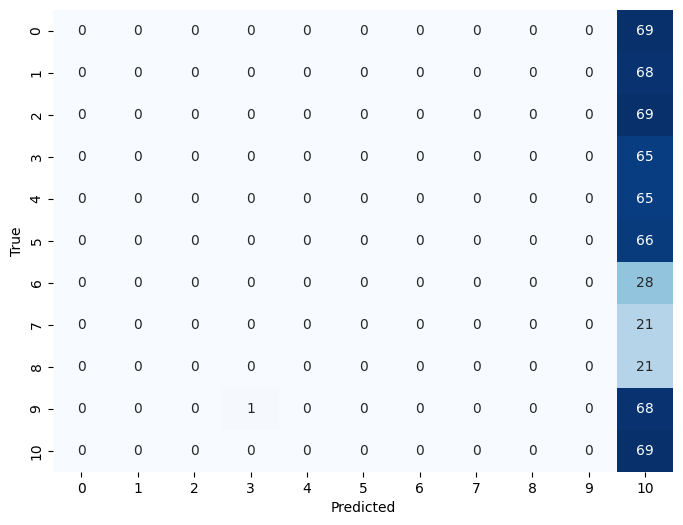

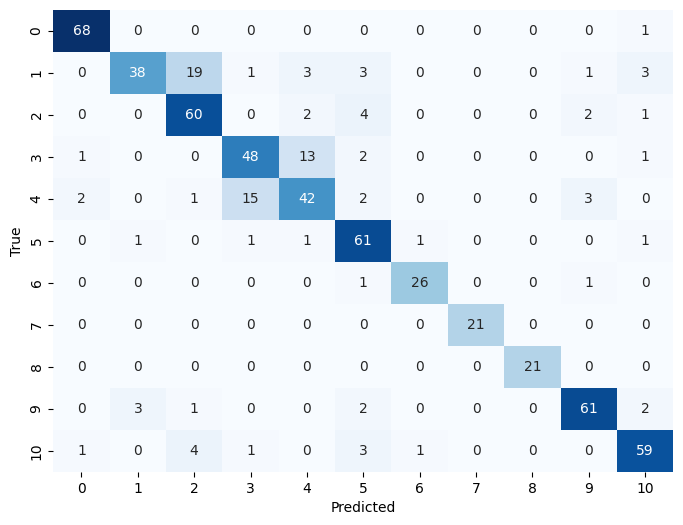

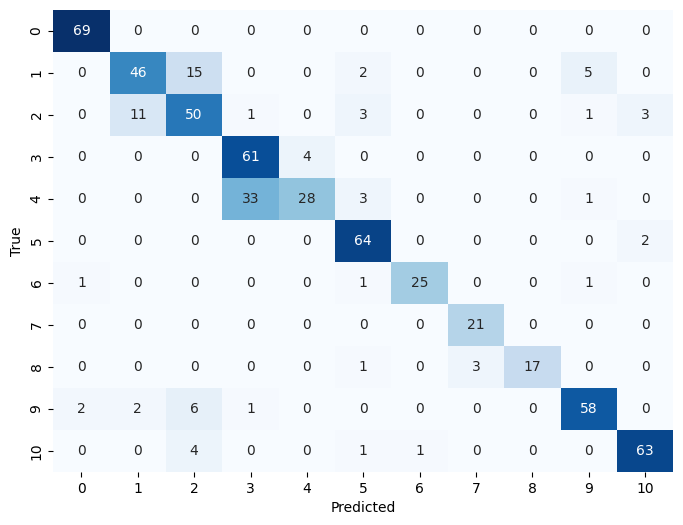

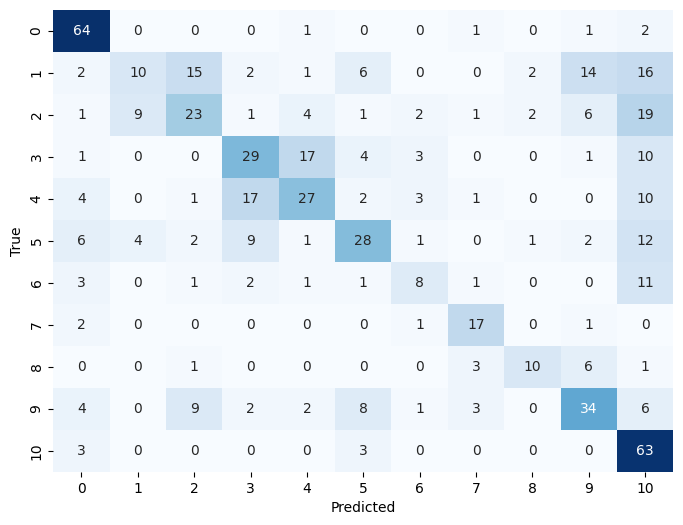

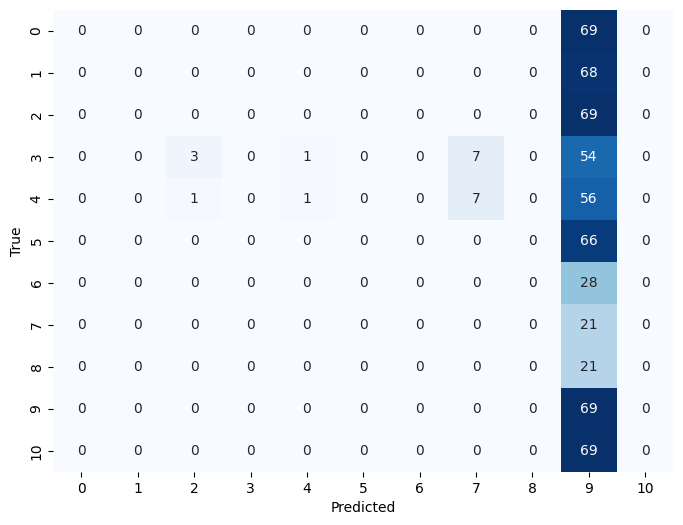

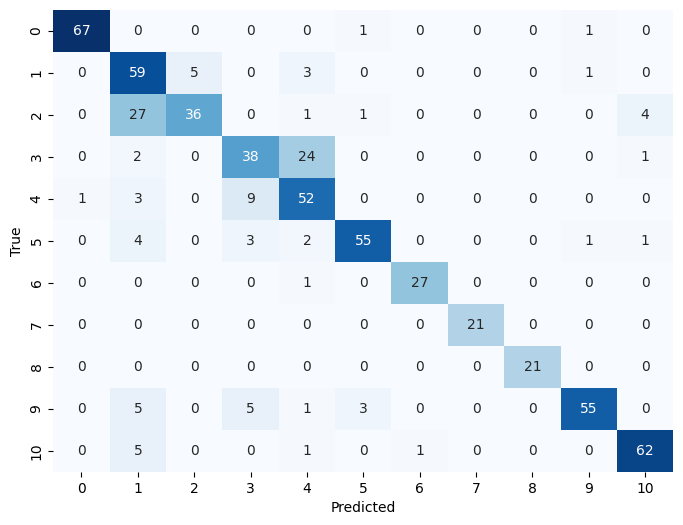

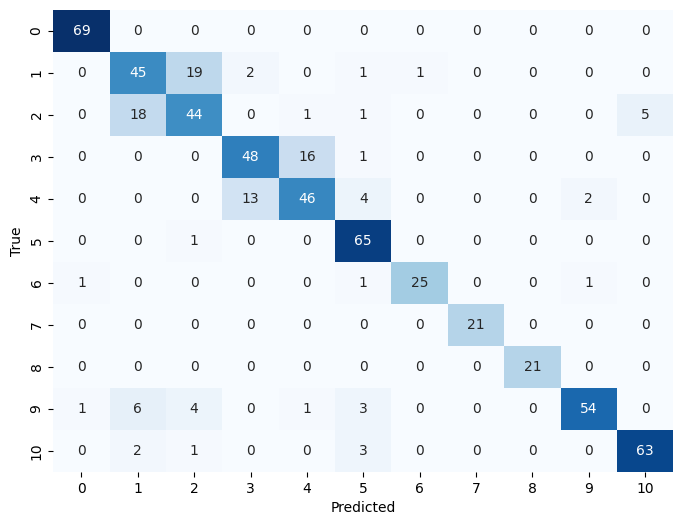

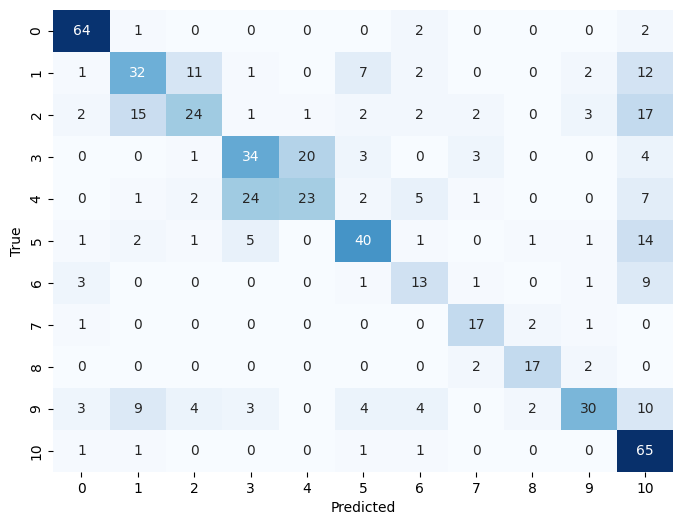

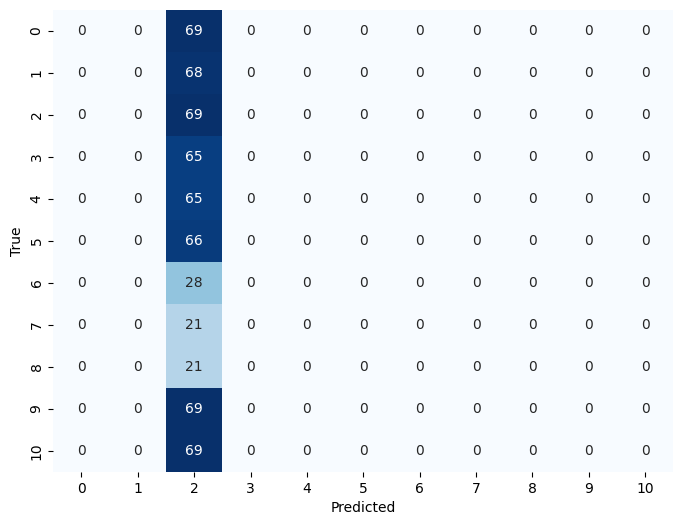

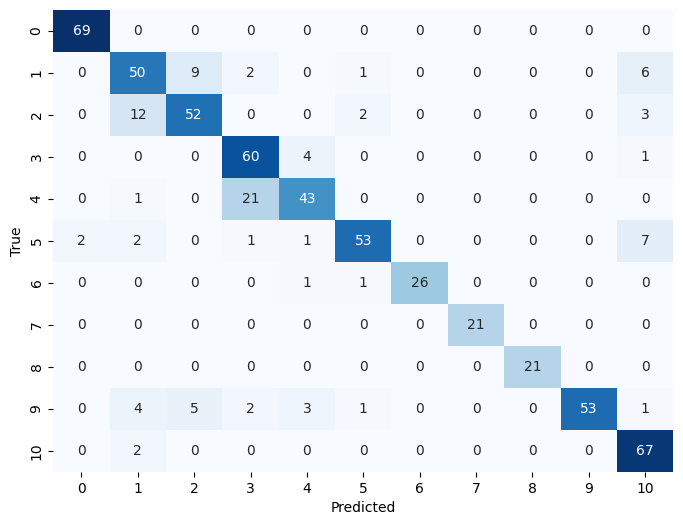

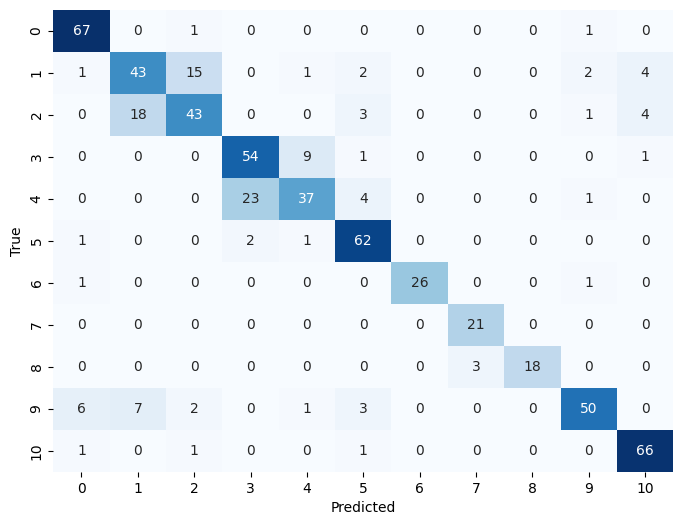

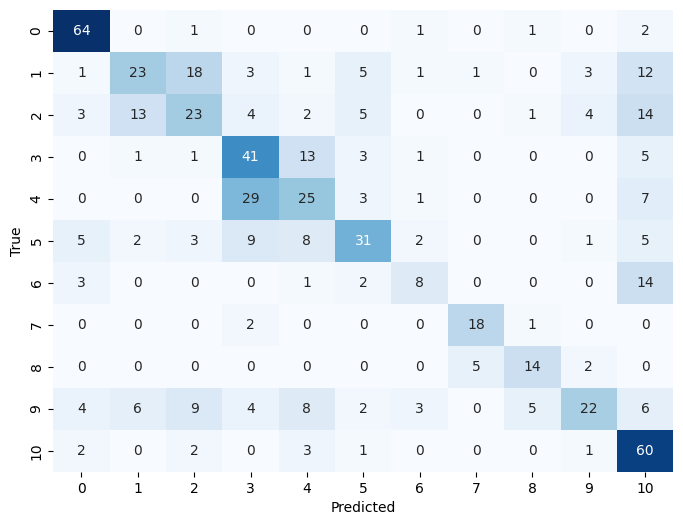

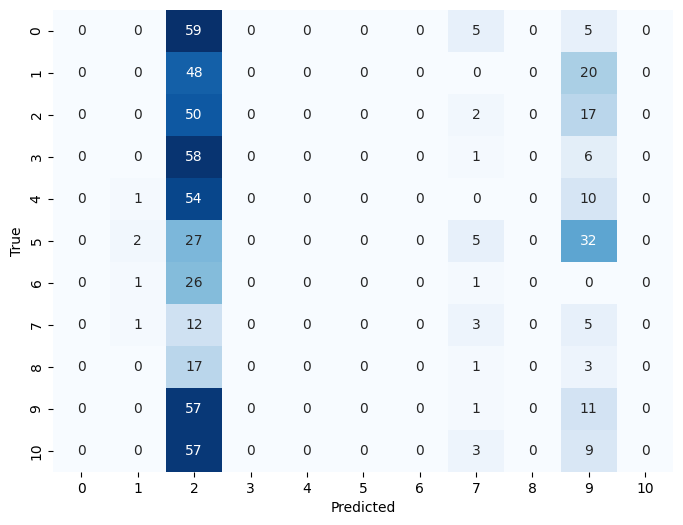

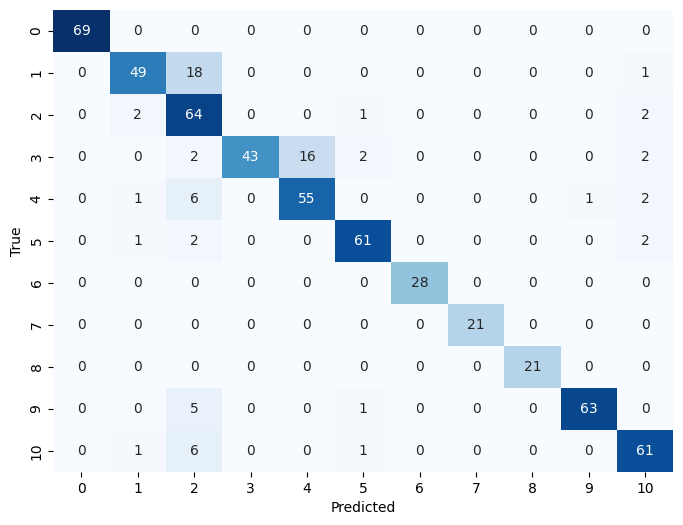

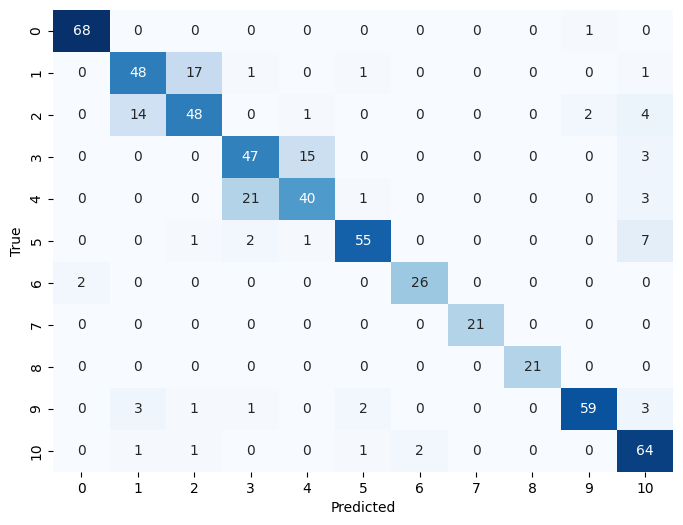

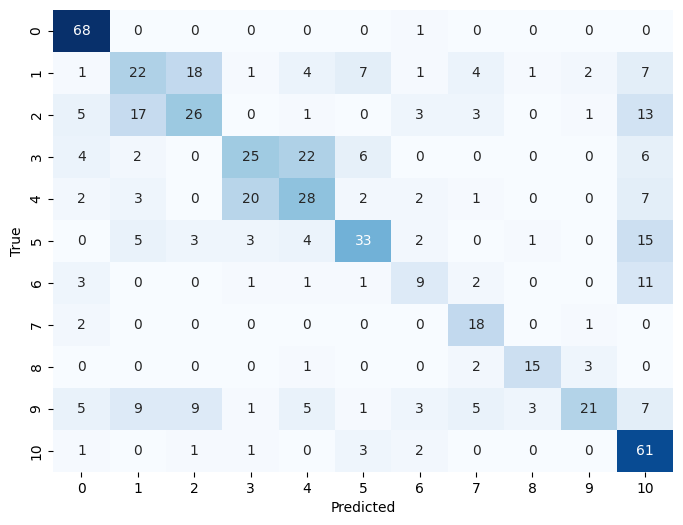

In [4]:
data_flag = 'organmnist3d'
download = True

DEVICE = 'cpu'
NUM_EPOCHS = 25
BATCH_SIZE = 16
milestones = [0.5 * NUM_EPOCHS, 0.75 * NUM_EPOCHS]
lr = 0.001
gamma = 0.1

output_root = './output3d'

info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
task = info['task']

augmentations = None
hyperparameters = f'g:{gamma}_eps{NUM_EPOCHS}_bs{BATCH_SIZE}_lr{lr}_aug{augmentations}'

train_loader, train_loader_at_eval, val_loader, test_loader = extract_data_3d(data_flag, download, BATCH_SIZE)

# model = resnet18(pretrained=True)
# model.fc.out_features = n_classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, n_classes)
# model.name = 'resnet18'
# train_3d_model(model, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model, model.name, test_loader, hyperparameters, output_root)

# model2 = resnet34(pretrained=True)
# model2.fc.out_features = n_classes
# num_ftrs = model2.fc.in_features
# model2.fc = nn.Linear(num_ftrs, n_classes)
# model2.name = 'resnet34'
# train_3d_model(model2, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model2, model2.name, test_loader, hyperparameters, output_root)

# model3 = resnet50(pretrained=True)
# model3.fc.out_features = n_classes
# num_ftrs = model3.fc.in_features
# model3.fc = nn.Linear(num_ftrs, n_classes)
# model3.name = 'resnet50'
# train_3d_model(model3, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model3, model3.name, test_loader, hyperparameters, output_root)

# model = ResNet18(in_channels=n_channels, num_classes=n_classes)
# model.name = 'resnet18'
# train_3d_model(model, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model, model.name, test_loader, hyperparameters, output_root)

# model = ResNet34(in_channels=n_channels, num_classes=n_classes)
# model.name = 'resnet34'
# train_3d_model(model, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model, model.name, test_loader, hyperparameters, output_root)


# model = resnet50(pretrained=True)
# model.fc.out_features = n_classes
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, n_classes)
# model.name = 'resnet50'

bs_list = [32, 64, 128, 256]
lr_list = [0.01, 0.001, 0.0001, 0.00001]




counter = 0
for i in range(len(bs_list)):
    for j in range(len(lr_list)):
        print(f"Running iteration {counter} of {16}")
        counter += 1
        bs = bs_list[i]
        lr = lr_list[j]
        hyperparameters = f'g:{gamma}_eps{NUM_EPOCHS}_bs{bs}_lr{lr}_aug{augmentations}'

        model = efficientnet_v2_s(pretrained=True)
        model.classifier[1] = nn.Linear(1280, n_classes)
        model.name = 'efficientnet_v2_s'
        train_3d_model(model, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
        plot_confusion_matrix(model, model.name, test_loader, hyperparameters, output_root)


        # model2 = efficientnet_v2_s(pretrained=True)
        # model2.classifier[1] = nn.Linear(1280, n_classes)
        # train_3d_model(model, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
        # plot_confusion_matrix(model2, model.name, test_loader, hyperparameters, output_root)


# model4 = swin_v2_t(pretrained=True)
# model4.head.out_features = n_classes
# num_ftrs = model4.head.in_features
# model4.head = nn.Linear(num_ftrs, n_classes)
# model4.name = 'swin_v2_t'
# train_3d_model(model4, DEVICE, data_flag, milestones, gamma, output_root, task, train_loader, train_loader_at_eval, val_loader, test_loader, NUM_EPOCHS, lr, hyperparameters)
# plot_confusion_matrix(model4, model4.name, test_loader, hyperparameters, output_root)
